<a href="https://colab.research.google.com/github/amnnsharma/GlidePro/blob/main/Pump_Off_Control_SRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRP WELL SECTION


In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
import tqdm
from itertools import product
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/
df= pd.read_excel("SRP Well.xlsx", sheet_name='4')

import warnings
warnings.filterwarnings("ignore")


/content/drive/My Drive


In [4]:
df.columns=['date', 'voltage1', 'voltage1', 'voltage1','power1','name', 'current1', 'current2', 'current3', 'power2', 'status']
df = df.iloc[5:, :]
df.reset_index(drop=True, inplace=True)
#df['date'] = pd.to_datetime(df['date'])
df = df[df['status'] == 'ON']
df=df.drop(df.columns[[5, 10]], axis=1)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d %H:%M:%S')


In [5]:
def srp_load_analysis(df_all, df, average_current=-1):
    period=24
    advanced_decomposition = STL(df_all.current1, period=period).fit()
    trend=advanced_decomposition.trend.to_list()[:df.shape[0]]
    #print(len(trend))

    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

    #ax1.plot( advanced_decomposition.observed)
    #ax1.set_ylabel('Observed')

    #ax2.plot(advanced_decomposition.trend)
    #ax2.set_ylabel('Trend')

    #ax3.plot(advanced_decomposition.seasonal)
    #ax3.set_ylabel('Seasonal')

    #ax4.plot(advanced_decomposition.resid)
    #ax4.set_ylabel('Residuals')


    #fig.autofmt_xdate()
    #plt.tight_layout()


    df['date'] = pd.to_datetime(df['date'])

    message_high=False
    message_low=False
    if average_current==-1:
      average_current=sum(trend[:period])/len(trend[:period])
    x_low=[]
    y_low=[]
    x_ok=[]
    y_ok=[]
    x_high=[]
    y_high=[]
    offset_factor=0.1
    up_limit=1+offset_factor
    low_limit=1-offset_factor
    for i in range(len(trend)):

      if (trend[i]> average_current and trend[i]>up_limit*average_current):
        x_high.append(df['date'].to_list()[i])
        y_high.append(trend[i])
        if message_high==False:
          x_high.append(df['date'].to_list()[i])
          y_high.append(trend[i])
          #print("ALERT:")
          #print("Since "+str(df['date'].to_list()[i]))
          #print("#Load is increasing on the SRP system")
          #print("#Unit balancing needed")
          message_high=True
          message_low=False

      elif (trend[i]< average_current and trend[i]<low_limit*average_current):
        x_low.append(df['date'].to_list()[i])
        y_low.append(trend[i])
        if message_low==False:
          x_low.append(df['date'].to_list()[i])
          y_low.append(trend[i])
          #print("ALERT:")
          #print("Since "+str(df['date'].to_list()[i]))
          #print("#Load is decreasing on the SRP system")
          #print("#Unit balancing needed")
          message_high=False
          message_low=True

      else:
        average_current=average_current*0.95 + trend[i]*0.05  #Giving 5 % weightage to new within limit currents
        x_ok.append(df['date'].to_list()[i])
        y_ok.append(trend[i])
        message_high=False
        message_low=False
      #print(average_current)

    fig, ax=plt.subplots(figsize=(10, 6))

    ax.plot(x_high, y_high, color='red', linestyle='', label="Load increased", marker='.')
    ax.plot(x_ok, y_ok, color='blue', linestyle='', label="Nominal Load", marker='.')
    ax.plot(x_low, y_low, color='y', linestyle='', label="Load decreased", marker='.')

    ax.set_yticklabels([])
    ax.set_xlabel("Date")
    ax.set_ylabel("Current Trend")
    #fig.autofmt_xdate()
    #plt.tight_layout()
    ax.legend()

    #plt.plot()
    #ax.plot()
    #plt.show()
    return fig, ax, average_current

In [6]:
distribute=90
df.reset_index()
df_all=df
df_top = df.iloc[:int(len(df) * distribute/100)]  #Top 80% of dataset
df_top['date'] = pd.to_datetime(df_top['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
#average_current_top=sum(df_top['current1'].to_list())/len(df_top['current1'].to_list())

df_bottom= df.iloc[int(len(df) * distribute/100):].reset_index()#Bottom 20% of dataset
df_bottom['date'] = pd.to_datetime(df_bottom['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

ALERT:
Since 2024-03-30 18:03:24
#Load is increasing on the SRP system
#Unit balancing needed


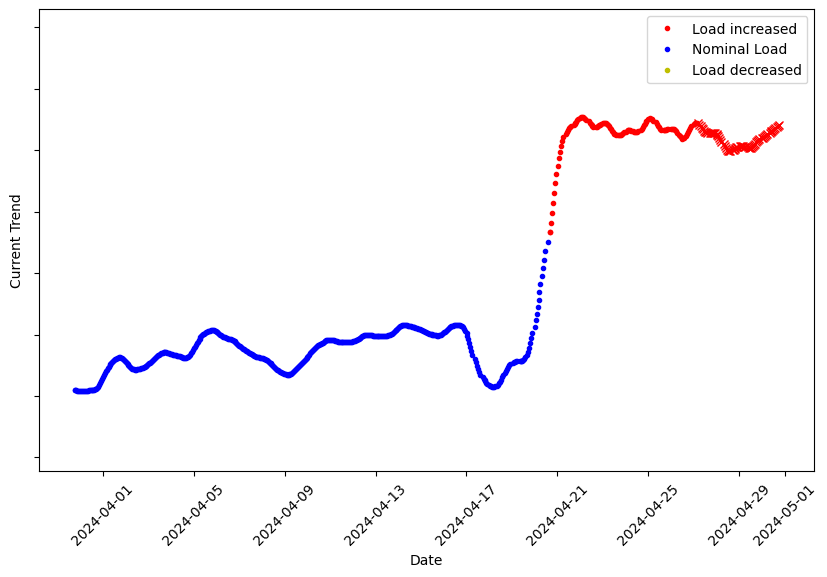

In [7]:
#%matplotlib notebook
period=24
advanced_decomposition = STL(df.current1, period=period).fit()

trend_all=STL(df.current1, period=period).fit().trend.to_list()
trend=advanced_decomposition.trend.to_list()[int(len(df) * distribute/100):]

offset_factor=0.1
up_limit=1+offset_factor
low_limit=1-offset_factor

#fig, ax=plt.subplots(figsize=(10, 6))

fig, ax, average_current_top= srp_load_analysis(df_all, df_top)
#print(average_current_top)
#ax.plot()
#average_current_top=6.5

#fig, ax=plt.subplots(figsize=(10, 6))
#plt.show()

message_high=False
message_low=False
df_bottom_dates=pd.to_datetime(df_bottom['date'])
#print(df_bottom_dates)

for i, row in df_bottom.iterrows():
      #print(i)
      if (trend[i]> average_current_top and trend[i]>up_limit*average_current_top):
        #print(df_bottom['date'].to_list()[i])
        ax.plot(df_bottom_dates[i],trend[i], color='red', linestyle='', label="Load increased", marker='x')
        if message_high==False:
          print("ALERT:")
          print("Since "+str(df['date'].to_list()[i]))
          print("#Load is increasing on the SRP system")
          print("#Unit balancing needed")
          message_high=True
          message_low=False

      elif (trend[i]< average_current_top and trend[i]<low_limit*average_current_top):
        ax.plot( df_bottom_dates[i],trend[i], color='y', linestyle='', label="Load decreased", marker='x')
        if message_low==True:
          print("ALERT:")
          print("Since "+str(df['date'].to_list()[i]))
          print("#Load is decreasing on the SRP system")
          print("#Unit balancing needed")
          message_high=False
          message_low=True

      else:
        ax.plot( df_bottom_dates[i],trend[i], color='blue', linestyle='', label="Nominal Load", marker='x')
        message_high=False
        message_low=False

      #fig.autofmt_xdate()
      #plt.tight_layout()
      #ax.set_xlim(min(df_top['date']), max(df_bottom['date']))
      ax.set_ylim(min(trend_all)*0.9, max(trend_all)*1.1)
      ax.set_xlabel("Date")
      ax.set_ylabel("Current Trend")
      #fig.autofmt_xdate()
      #plt.tight_layout()
      #ax.legend()
      plt.xticks(rotation=45)

plt.show()
#srp_load_analysis(df)

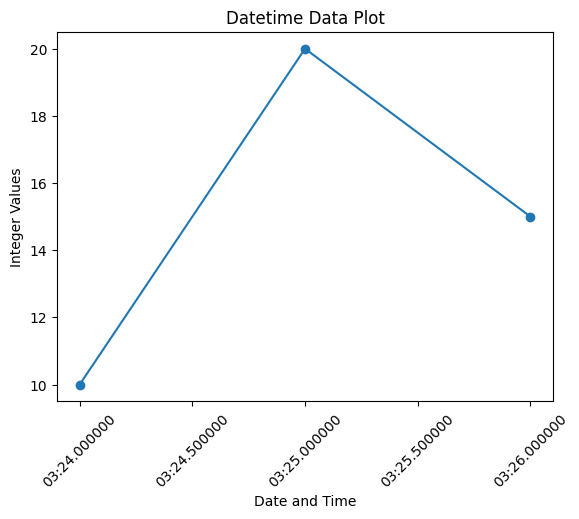

Hi
Hi


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Example datetime data
datetime_data = ['2024-04-20 16:03:24', '2024-04-20 16:03:25', '2024-04-20 16:03:26']
integer_values = [10, 20, 15]

# Convert datetime strings to datetime objects
datetime_objects = pd.to_datetime(datetime_data)

# Create a subplot
fig, ax = plt.subplots()

# Plot initial data on the same axis
ax.plot(datetime_objects, integer_values, marker='o', label='Initial Data')

# Set labels and title
ax.set_xlabel('Date and Time')
ax.set_ylabel('Integer Values')
ax.set_title('Datetime Data Plot')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot initially
plt.show()

time.sleep(2)
plt.close()
# Define additional data
additional_datetime_data = ['2024-04-20 16:03:27', '2024-04-20 16:03:28']
additional_integer_values = [25, 30]

# Convert additional datetime strings to datetime objects
additional_datetime_objects = pd.to_datetime(additional_datetime_data)

# Plot additional data on the same axis in a for loop
for i in range(len(additional_datetime_objects)):
    print("Hi")
    ax.plot(additional_datetime_objects[i], additional_integer_values[i], marker='x', color='red', label='Additional Data')
    plt.show()  # Display the plot with the additional data after each iteration

# Show the final plot with all data
plt.show()



In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
import tqdm
from itertools import product
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import time
import openpyxl


import warnings
warnings.filterwarnings("ignore")


df= pd.read_excel("Data\SRP Well.xlsx", sheet_name='4')

df.columns=['date', 'voltage1', 'voltage1', 'voltage1','power1','name', 'current1', 'current2', 'current3', 'power2', 'status']
df = df.iloc[5:, :]
df.reset_index(drop=True, inplace=True)
#df['date'] = pd.to_datetime(df['date'])
df = df[df['status'] == 'ON']
df=df.drop(df.columns[[5, 10]], axis=1)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d %H:%M:%S')


def srp_load_analysis(df_all, df, average_current=-1):
    period=24
    advanced_decomposition = STL(df_all.current1, period=period).fit()
    trend=advanced_decomposition.trend.to_list()[:df.shape[0]]
    #print(len(trend))

    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

    #ax1.plot( advanced_decomposition.observed)
    #ax1.set_ylabel('Observed')

    #ax2.plot(advanced_decomposition.trend)
    #ax2.set_ylabel('Trend')

    #ax3.plot(advanced_decomposition.seasonal)
    #ax3.set_ylabel('Seasonal')

    #ax4.plot(advanced_decomposition.resid)
    #ax4.set_ylabel('Residuals')


    #fig.autofmt_xdate()
    #plt.tight_layout()


    df['date'] = pd.to_datetime(df['date'])

    message_high=False
    message_low=False
    if average_current==-1:
      average_current=sum(trend[:period])/len(trend[:period])
    x_low=[]
    y_low=[]
    x_ok=[]
    y_ok=[]
    x_high=[]
    y_high=[]
    offset_factor=0.1
    up_limit=1+offset_factor
    low_limit=1-offset_factor
    for i in range(len(trend)):

        if (trend[i]> average_current and trend[i]>up_limit*average_current):
            x_high.append(df['date'].to_list()[i])
            y_high.append(trend[i])
            if message_high==False:
                #print("ALERT:")
                #print("Since "+str(df['date'].to_list()[i]))
                #print("#Load is increasing on the SRP system")
                #print("#Unit balancing needed")
                message_high=True
                message_low=False

        elif (trend[i]< average_current and trend[i]<low_limit*average_current):
            x_low.append(df['date'].to_list()[i])
            y_low.append(trend[i])
            if message_low==False:
                #print("ALERT:")
                #print("Since "+str(df['date'].to_list()[i]))
                #print("#Load is decreasing on the SRP system")
                #print("#Unit balancing needed")
                message_high=False
                message_low=True

        else:
            average_current=average_current*0.95 + trend[i]*0.05  #Giving 5 % weightage to new within limit currents
            x_ok.append(df['date'].to_list()[i])
            y_ok.append(trend[i])
            message_high=False
            message_low=False
            #print(average_current)



    #plt.plot()
    #ax.plot()
    #plt.show()
    return [x_low, x_ok, x_high], [y_low, y_ok, y_high] , average_current

distribute=70
df.reset_index()
df_all=df
df_top = df.iloc[:int(len(df) * distribute/100)]  #Top 80% of dataset
df_top['date'] = pd.to_datetime(df_top['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
#average_current_top=sum(df_top['current1'].to_list())/len(df_top['current1'].to_list())

df_bottom= df.iloc[int(len(df) * distribute/100):].reset_index()#Bottom 20% of dataset
df_bottom['date'] = pd.to_datetime(df_bottom['date']).dt.strftime('%Y-%m-%d %H:%M:%S')


#%matplotlib notebook
period=24
advanced_decomposition = STL(df.current1, period=period).fit()

trend_all=STL(df.current1, period=period).fit().trend.to_list()
trend=advanced_decomposition.trend.to_list()[int(len(df) * distribute/100):]

offset_factor=0.1
up_limit=1+offset_factor
low_limit=1-offset_factor

#fig, ax=plt.subplots(figsize=(10, 6))

[x_low, x_ok, x_high], [y_low, y_ok, y_high], average_current_top= srp_load_analysis(df_all, df_top)
#print(average_current_top)
#ax.plot()
#average_current_top=6.5

#fig, ax=plt.subplots(figsize=(10, 6))
#plt.show()

message_high=False
message_low=False
df_bottom_dates=pd.to_datetime(df_bottom['date'])
#print(df_bottom_dates)


fig, ax=plt.subplots(figsize=(10, 6))

def animate(j):
    for i, row in df_bottom.iterrows():

        #time.sleep(1)
        #plt.close()
        #print(i)
        if (trend[i]> average_current_top and trend[i]>up_limit*average_current_top):
            #print(df_bottom['date'].to_list()[i])
            x_high.append(df_bottom_dates[i])
            y_high.append(trend[i])
            if message_high==False:
                print("ALERT:")
                print("Since "+str(df['date'].to_list()[i]))
                print("#Load is increasing on the SRP system")
                print("#Unit balancing needed")
                message_high=True
                message_low=False

        elif (trend[i]< average_current_top and trend[i]<low_limit*average_current_top):
            x_low.append(df_bottom_dates[i])
            y_low.append(trend[i])
            if message_low==True:
                print("ALERT:")
                print("Since "+str(df['date'].to_list()[i]))
                print("#Load is decreasing on the SRP system")
                print("#Unit balancing needed")
                message_high=False
                message_low=True

        else:
            x_ok.append(df_bottom_dates[i])
            y_ok.append(trend[i])
            message_high=False
            message_low=False

        #fig.autofmt_xdate()
        #plt.tight_layout()
        #ax.set_xlim(min(df_top['date']), max(df_bottom['date']))
        plt.plot(x_high, y_high, color='red', linestyle='', label="Load increased", marker='.')
        plt.plot(x_ok, y_ok, color='blue', linestyle='', label="Nominal Load", marker='.')
        plt.plot(x_low, y_low, color='y', linestyle='', label="Load decreased", marker='.')

        #plt.set_yticklabels([])
        plt.xlabel("Date")
        plt.ylabel("Current Trend")
        #fig.autofmt_xdate()
        #plt.tight_layout()
        #ax.legend()



from matplotlib.animation import FuncAnimation
ani= FuncAnimation(plt.gcf(), animate, interval=10000)

plt.show()
    #srp_load_analysis(df)

[]

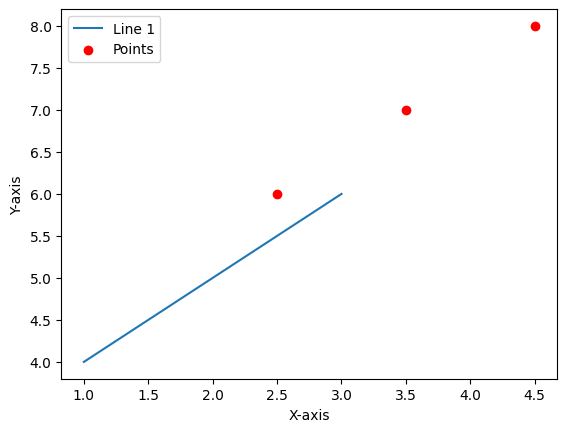

In [ ]:
import matplotlib.pyplot as plt

# Example existing axis
fig, ax = plt.subplots()

# Plot something on the existing axis
x1 = [1, 2, 3]
y1 = [4, 5, 6]
ax.plot(x1, y1, label='Line 1')

# Further plot some points on the same axis
x2 = [2.5, 3.5, 4.5]
y2 = [6, 7, 8]
ax.scatter(x2, y2, color='red', label='Points')

# Set labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()

# Show plot
plt.show()


In [ ]:
'''
import matplotlib.pyplot as plt

# Sample list
data = [3, 7, 12, 2, 8, 15, 4, 6, 9, 11]

# Plot the data
for i, value in enumerate(data):
    if value > 10:
        plt.plot([i, i+1], [value, data[i+1]], color='red')
    elif value < 5:
        plt.plot([i, i+1], [value, data[i+1]], color='yellow')
    else:
        plt.plot([i, i+1], [value, data[i+1]], color='green')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Colorful Lines Plot')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Sample list\ndata = [3, 7, 12, 2, 8, 15, 4, 6, 9, 11]\n\n# Plot the data\nfor i, value in enumerate(data):\n    if value > 10:\n        plt.plot([i, i+1], [value, data[i+1]], color='red')\n    elif value < 5:\n        plt.plot([i, i+1], [value, data[i+1]], color='yellow')\n    else:\n        plt.plot([i, i+1], [value, data[i+1]], color='green')\n\nplt.xlabel('Index')\nplt.ylabel('Value')\nplt.title('Colorful Lines Plot')\nplt.show()\n"

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [ ]:
ADF_result = adfuller(np.diff(df.current1, n=1))

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.683277932360838
p-value: 4.229239272725036e-14


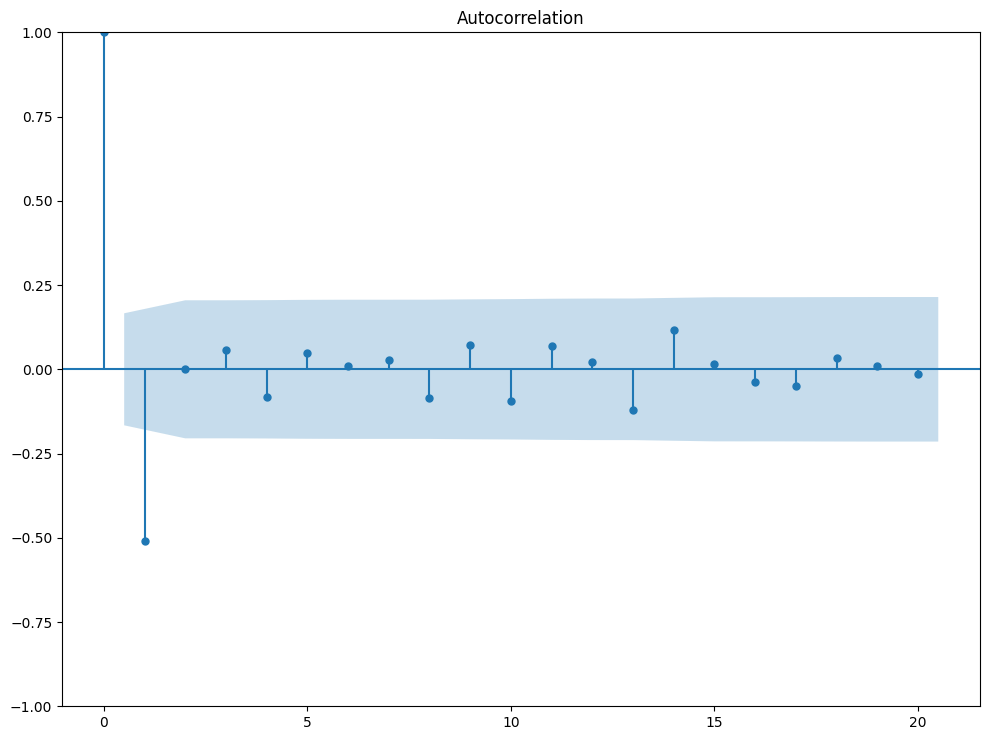

In [ ]:
plot_acf(np.diff(df.current1, n=1), lags=20)

plt.tight_layout()

In [ ]:
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
df=df[['date', 'current1']]
df.columns=['ds','y']
train = df[:-100]
test = df[-100:]

In [ ]:
train['ds']=pd.to_datetime(train['ds'])
train.shape

(40, 2)

In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
test['ds']=pd.to_datetime(test['ds'])
test.shape

(100, 2)

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=100, freq='H')
print(future.shape)
forecast = m.predict(future)
print(forecast.shape)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph21e2d3_/ubtngazs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph21e2d3_/uyx81rtv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66988', 'data', 'file=/tmp/tmph21e2d3_/ubtngazs.json', 'init=/tmp/tmph21e2d3_/uyx81rtv.json', 'output', 'file=/tmp/tmph21e2d3_/prophet_modelw88dar69/prophet_model-20240501102318.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:18 - cmdstanpy - INFO - Chai

(140, 1)
(140, 13)


,ds,yhat,yhat_lower,yhat_upper
0,2024-04-23 15:59:29,27.019407,22.403324,31.749270
1,2024-04-23 16:59:29,26.983569,22.578948,31.275817
2,2024-04-23 17:59:29,26.947730,22.151855,31.704531
3,2024-04-23 18:59:29,26.911892,22.319574,31.769158
4,2024-04-23 19:59:29,26.876053,22.240412,31.251744
...,...,...,...,...
135,2024-04-29 07:59:29,22.145429,17.139841,26.829001
136,2024-04-29 08:59:29,22.109592,17.581174,26.550586
137,2024-04-29 09:59:29,22.073754,17.699648,27.087524
138,2024-04-29 10:59:29,22.037916,17.229217,26.621688


All plots done


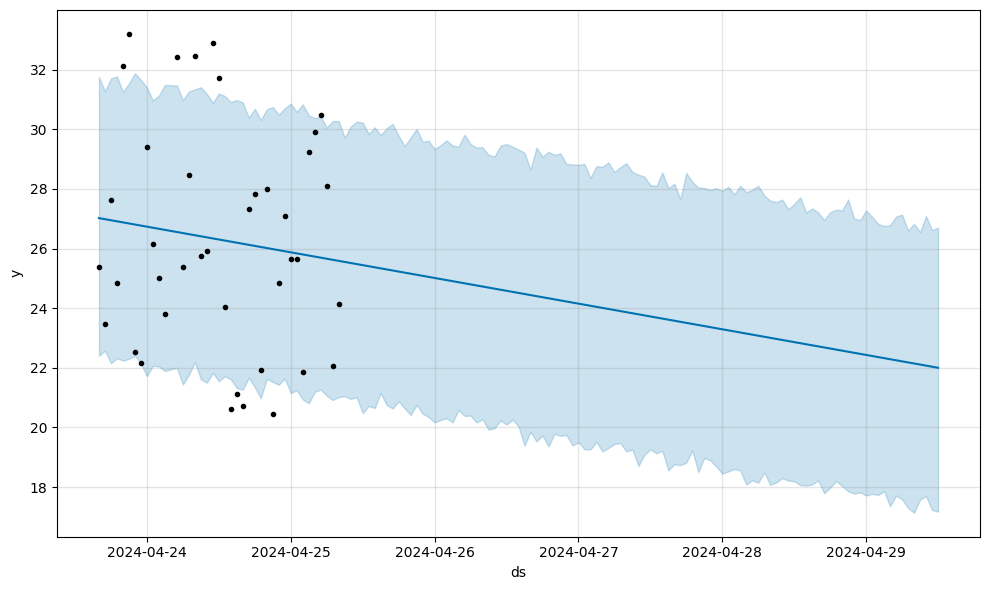

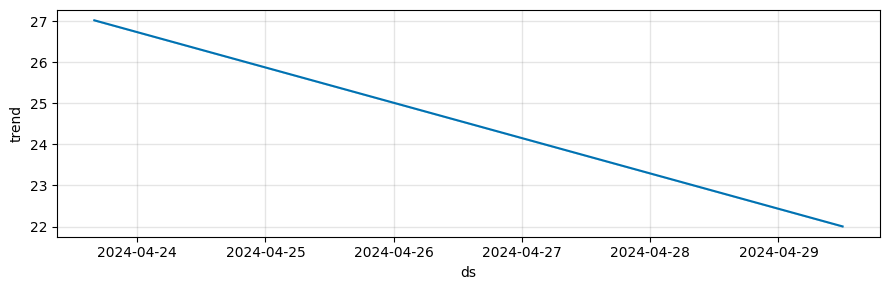

In [ ]:
m.plot(forecast)
m.plot_components(forecast)
print("All plots done")

In [ ]:
forecast.reset_index(drop=True, inplace=True)

In [ ]:
forecast.shape

(140, 13)

In [ ]:
test

,ds,y
0,2024-04-25 08:59:29,30.238852
1,2024-04-25 09:59:29,31.100456
2,2024-04-25 10:59:29,29.020000
3,2024-04-25 11:59:29,24.841663
4,2024-04-25 12:59:29,31.185566
...,...,...
95,2024-04-30 11:59:29,19.376095
96,2024-04-30 12:59:29,20.339289
97,2024-04-30 13:59:29,20.194452
98,2024-04-30 14:59:29,20.065140


In [ ]:
forecast=forecast[['yhat', 'yhat_lower', 'yhat_upper']][-50:]

In [ ]:
forecast.reset_index(drop=True, inplace=True)

In [ ]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2024-04-25 08:59:29,30.238852,23.758138,19.077320,28.414006
1,2024-04-25 09:59:29,31.100456,23.722300,19.268379,28.125821
2,2024-04-25 10:59:29,29.020000,23.686462,19.132978,28.095383
3,2024-04-25 11:59:29,24.841663,23.650624,19.216202,28.550856
4,2024-04-25 12:59:29,31.185566,23.614786,18.557538,28.025385


In [ ]:
test['baseline'] = train['y'][-100:].values
test.head()

ValueError: Length of values (40) does not match length of index (100)

In [ ]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

In [ ]:
test.iloc[49]

In [ ]:
test.index = range(int(train.shape[0]), 50 + int(train.shape[0]))

In [ ]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Current')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

#plt.xticks(
#    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
#    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(0, test.shape[0]+train.shape[0])

fig.autofmt_xdate()
#plt.tight_layout()

#plt.savefig('figures/CH19_F03_peixeiro.png', dpi=300)

In [ ]:
#m.plot(forecast)